<a href="https://colab.research.google.com/github/kmenesesrivera/codonusagebias/blob/main/Codon_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sklearn as sk
import joblib
from google.colab import files
from sklearn.ensemble import RandomForestClassifier 
import pickle


data1 = pd.read_csv('https://drive.google.com/uc?export=download&id=1Z4v43cvTwp920NyOdboDKP7_ytC_0tBC')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data1.head(5)

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,AUG,GUU,GUC,GUA,GUG,GCU,GCC,GCA,GCG,CCU,CCC,CCA,CCG,UGG,GGU,GGC,GGA,GGG,UCU,UCC,UCA,UCG,AGU,AGC,ACU,ACC,ACA,ACG,UAU,UAC,CAA,CAG,AAU,AAC,UGU,UGC,CAU,CAC,AAA,AAG,CGU,CGC,CGA,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,0.02005,0.00752,0.02506,0.01103,0.04110,0.00902,0.03308,0.01003,0.05013,0.01554,0.01103,0.02356,0.03208,0.01203,0.00501,0.01003,0.01203,0.03158,0.01905,0.02456,0.01353,0.02155,0.00251,0.00652,0.00150,0.01554,0.00501,0.02105,0.00902,0.01053,0.00501,0.02256,0.00301,0.03108,0.00401,0.02607,0.00251,0.01153,0.00501,0.02356,0.01053,0.03860,0.00401,0.00702,0.00401,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,0.02510,0.00882,0.03324,0.00814,0.04071,0.00814,0.03256,0.01085,0.04885,0.01221,0.01357,0.00678,0.02714,0.01221,0.00407,0.01425,0.01221,0.01967,0.02239,0.01289,0.02103,0.01493,0.00407,0.00475,0.00068,0.02035,0.00950,0.02782,0.01425,0.00611,0.00475,0.02917,0.00407,0.02374,0.00882,0.02917,0.00271,0.01628,0.00204,0.01967,0.00543,0.03392,0.00136,0.00678,0.00136,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,0.01604,0.01316,0.02180,0.01625,0.01872,0.01213,0.01070,0.02406,0.01234,0.01440,0.00514,0.01604,0.01460,0.02098,0.01070,0.01728,0.01851,0.00864,0.01172,0.01892,0.01933,0.01419,0.01296,0.00967,0.01337,0.01337,0.01851,0.01131,0.01419,0.01090,0.02612,0.01275,0.01522,0.02365,0.02962,0.01789,0.01625,0.01234,0.01604,0.01687,0.02077,0.03949,0.00864,0.00596,0.00926,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,0.02245,0.02507,0.02924,0.02089,0.02141,0.01723,0.01932,0.02141,0.00679,0.02245,0.00522,0.01358,0.00418,0.01410,0.00574,0.01201,0.00992,0.00366,0.02402,0.02663,0.02872,0.00992,0.02350,0.00522,0.01619,0.00836,0.02037,0.01358,0.02089,0.00731,0.02141,0.00888,0.01567,0.01253,0.02298,0.01358,0.00992,0.00888,0.00783,0.00679,0.03133,0.04282,0.00627,0.00261,0.00261,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,0.00867,0.01310,0.02773,0.02803,0.00508,0.00920,0.02965,0.02878,0.00574,0.01572,0.01577,0.01007,0.00508,0.00604,0.00679,0.01205,0.03127,0.00775,0.00959,0.00797,0.02006,0.00359,0.00933,0.01191,0.01616,0.00788,0.02593,0.00854,0.01200,0.02098,0.02089,0.01367,0.01502,0.01809,0.02738,0.01796,0.01082,0.00705,0.01174,0.00858,0.03408,0.03964,0.00950,0.00429,0.00578,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [ ]:
data1.dtypes

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
                ...   
GAA            float64
GAG            float64
UAA            float64
UAG            float64
UGA            float64
Length: 69, dtype: object

In [ ]:
# Verificamos que aún hay columnas que deberían ser númericas.

cols = data1.columns[data1.dtypes.eq(object)] 
cols

Index(['Kingdom', 'SpeciesName', 'UUU', 'UUC'], dtype='object')

In [ ]:
data1.shape

(13028, 69)

In [ ]:
data1.isna().sum().sort_values()

Kingdom    0
UCA        0
UCG        0
AGU        0
AGC        0
          ..
GUG        0
GUA        0
GUC        0
GCG        0
UGA        0
Length: 69, dtype: int64

In [ ]:
# Se observa que hay datos str que no permiten manipular los demás como numéricos.
data1[['UUU', 'UUC']] = data1[['UUU', 'UUC']].apply(pd.to_numeric, errors='coerce')
null_UUU = data1['UUU'].isna().sum()
null_UUC= data1['UUC'].isna().sum()
print ("Cantidad de datos nulos en codon UUU ",null_UUU)
print ("Cantidad de datos nuls en codon UUC ",null_UUC)


Cantidad de datos nulos en codon UUU  2
Cantidad de datos nuls en codon UUC  1


In [ ]:
#Lectura del dataset
 
data1.describe

data1.head(5)
 

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,AUG,GUU,GUC,GUA,GUG,GCU,GCC,GCA,GCG,CCU,CCC,CCA,CCG,UGG,GGU,GGC,GGA,GGG,UCU,UCC,UCA,UCG,AGU,AGC,ACU,ACC,ACA,ACG,UAU,UAC,CAA,CAG,AAU,AAC,UGU,UGC,CAU,CAC,AAA,AAG,CGU,CGC,CGA,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,0.02005,0.00752,0.02506,0.01103,0.04110,0.00902,0.03308,0.01003,0.05013,0.01554,0.01103,0.02356,0.03208,0.01203,0.00501,0.01003,0.01203,0.03158,0.01905,0.02456,0.01353,0.02155,0.00251,0.00652,0.00150,0.01554,0.00501,0.02105,0.00902,0.01053,0.00501,0.02256,0.00301,0.03108,0.00401,0.02607,0.00251,0.01153,0.00501,0.02356,0.01053,0.03860,0.00401,0.00702,0.00401,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,0.02510,0.00882,0.03324,0.00814,0.04071,0.00814,0.03256,0.01085,0.04885,0.01221,0.01357,0.00678,0.02714,0.01221,0.00407,0.01425,0.01221,0.01967,0.02239,0.01289,0.02103,0.01493,0.00407,0.00475,0.00068,0.02035,0.00950,0.02782,0.01425,0.00611,0.00475,0.02917,0.00407,0.02374,0.00882,0.02917,0.00271,0.01628,0.00204,0.01967,0.00543,0.03392,0.00136,0.00678,0.00136,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,0.01604,0.01316,0.02180,0.01625,0.01872,0.01213,0.01070,0.02406,0.01234,0.01440,0.00514,0.01604,0.01460,0.02098,0.01070,0.01728,0.01851,0.00864,0.01172,0.01892,0.01933,0.01419,0.01296,0.00967,0.01337,0.01337,0.01851,0.01131,0.01419,0.01090,0.02612,0.01275,0.01522,0.02365,0.02962,0.01789,0.01625,0.01234,0.01604,0.01687,0.02077,0.03949,0.00864,0.00596,0.00926,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,0.02245,0.02507,0.02924,0.02089,0.02141,0.01723,0.01932,0.02141,0.00679,0.02245,0.00522,0.01358,0.00418,0.01410,0.00574,0.01201,0.00992,0.00366,0.02402,0.02663,0.02872,0.00992,0.02350,0.00522,0.01619,0.00836,0.02037,0.01358,0.02089,0.00731,0.02141,0.00888,0.01567,0.01253,0.02298,0.01358,0.00992,0.00888,0.00783,0.00679,0.03133,0.04282,0.00627,0.00261,0.00261,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,0.00867,0.01310,0.02773,0.02803,0.00508,0.00920,0.02965,0.02878,0.00574,0.01572,0.01577,0.01007,0.00508,0.00604,0.00679,0.01205,0.03127,0.00775,0.00959,0.00797,0.02006,0.00359,0.00933,0.01191,0.01616,0.00788,0.02593,0.00854,0.01200,0.02098,0.02089,0.01367,0.01502,0.01809,0.02738,0.01796,0.01082,0.00705,0.01174,0.00858,0.03408,0.03964,0.00950,0.00429,0.00578,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [ ]:
def preprocess_dataset(dataset, save_metadata=True):
  
  preprocessed_dataset = dataset.copy()

  #Determinamos aquellas variables que tengan un porcentaje de registros únicos por cada variable mayor al valor de 0.7
  threshold = 0.7

  unique_percentages = dataset.nunique() / len(dataset)

  criteria = unique_percentages > threshold

  columns_to_filter = unique_percentages[criteria].keys()
  
  # Está columna contiene datos descriptivos, por tanto será transformada a str.

  preprocessed_dataset['SpeciesName'] = preprocessed_dataset['SpeciesName'].astype(str)
  preprocessed_dataset['SpeciesName']
 
  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)
 
  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Determinamos que variables son del tipo númerico y cuales son categóricas
  numeric_columns = list()
  categorical_columns = list()
  dictionary_of_columns_with_index_to_categorical = dict()
  dictionary_of_columns_with_categorical_to_index = dict()

  for column in preprocessed_dataset:
    #Determinamos si la variable es numérica o no
    if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
      numeric_columns.append(column)
    else:
      #Modificamos el tipo de dato de la variable mediante "astype"
      preprocessed_dataset[column] = preprocessed_dataset[column].astype("category")

      #Verificamos si el tipo de dato de la variable fue transformado a categórico correctamente
      if not pd.api.types.is_categorical_dtype(preprocessed_dataset[column]):
        raise Exception("La columna {} no se transformó correctamente a categórica".format(column))

      dictionary_of_columns_with_index_to_categorical[column] = dict()
      dictionary_of_columns_with_categorical_to_index[column] = dict()
      
      #Indexamos los valores (categorías), sin tomar en consideración los nulos, de la variable y guardamos esa información en los diccionarios
      for index, category in enumerate(preprocessed_dataset[column].cat.categories):
        dictionary_of_columns_with_index_to_categorical[column][index] = category
        dictionary_of_columns_with_categorical_to_index[column][category] = index
      
      categorical_columns.append(column)
  
  #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
    median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()
    preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)

  #Transformamos a números los valores (categorías) de las variables categóricas sin considerar los nulos
  preprocessed_dataset.replace(dictionary_of_columns_with_categorical_to_index, inplace=True)

  #Determinamos aquellas variables que tengan un porcentaje de registros nulos por cada variable mayor al valor de 0.7
  threshold = 0.7

  null_percentages = preprocessed_dataset[categorical_columns].isna().sum() / len(preprocessed_dataset)

  criteria = null_percentages > threshold

  columns_to_filter = null_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  if save_metadata:
    #Guardamos información que consideremos imporante. **El formato pickle nos permite guardar objetos de python***
    with open("numeric_columns.pkl", "wb") as f:
      pickle.dump(numeric_columns, f)
    
    with open("categorical_columns.pkl", "wb") as f:
      pickle.dump(categorical_columns, f)
    
    with open("dictionary_of_columns_with_index_to_categorical.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_index_to_categorical, f)
    
    with open("dictionary_of_columns_with_categorical_to_index.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_categorical_to_index, f)
  
  return preprocessed_dataset

In [ ]:
#Transformamos los datos a valores numéricos
preprocessed_dataset = preprocess_dataset(data1)

#print ("preprocessed_dataset", preprocessed_dataset.describe) 

#Se redujo la cantidad de genomas luego de eliminar duplicados a 12991, se reemplaza nulos por la mediana, moda o se puede eliminar registros.

#print (preprocessed_dataset.isna().sum().sort_values())

In [ ]:
preprocessed_dataset.describe

<bound method NDFrame.describe of        Kingdom  DNAtype   Ncodons      UUU  ...      GAG      UAA      UAG      UGA
0            9        0      1995  0.01654  ...  0.04361  0.00251  0.00050  0.00000
1            9        0      1474  0.02714  ...  0.04410  0.00271  0.00068  0.00000
2            9        0      4862  0.01974  ...  0.02468  0.00391  0.00000  0.00144
3            9        0      1915  0.01775  ...  0.03446  0.00261  0.00157  0.00000
4            9        0     22831  0.02816  ...  0.03679  0.00000  0.00044  0.00131
...        ...      ...       ...      ...  ...      ...      ...      ...      ...
13023        7        0      1097  0.02552  ...  0.04102  0.00091  0.00091  0.00638
13024        7        1      2067  0.01258  ...  0.00677  0.00242  0.00097  0.01887
13025        7        1      1686  0.01423  ...  0.00297  0.00356  0.00119  0.02017
13026        7        0  40662582  0.01757  ...  0.03959  0.00099  0.00079  0.00156
13027        7        1   8998998  0.01778

In [ ]:
x = preprocessed_dataset.drop("Kingdom", axis=1)
x = preprocessed_dataset.drop("DNAtype", axis=1)
y = preprocessed_dataset["Kingdom"]  
y2 = preprocessed_dataset["DNAtype"] 


In [ ]:
 #Selección de Características

from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

filtrado = SelectKBest(mutual_info_classif, k=3).fit(x, y)

In [ ]:
filtrado.scores_

array([1.90067139, 0.2798956 , 0.21855715, 0.24140341, 0.2464687 ,
       0.27362439, 0.22642331, 0.27157493, 0.4853323 , 0.23635194,
       0.20875933, 0.28569981, 0.30380939, 0.25002668, 0.22106443,
       0.15057263, 0.15523978, 0.24512323, 0.18376745, 0.28669687,
       0.15828612, 0.32166199, 0.17962551, 0.23075987, 0.31373843,
       0.2921642 , 0.30219643, 0.2552301 , 0.28098515, 0.20807763,
       0.12536347, 0.23993594, 0.20083371, 0.24280827, 0.25311158,
       0.26227788, 0.17922743, 0.19115537, 0.25153641, 0.32820482,
       0.25946063, 0.20447932, 0.12718936, 0.20495668, 0.32462675,
       0.23973374, 0.16776047, 0.34004161, 0.2336519 , 0.21018343,
       0.20046275, 0.3054005 , 0.39142301, 0.30662527, 0.29724579,
       0.22873093, 0.23424386, 0.44934322, 0.46479679, 0.35030828,
       0.23681915, 0.2727022 , 0.32694844, 0.20958055, 0.06813068,
       0.44333666])

In [ ]:
filtrado.pvalues_

In [ ]:
x_new= filtrado.transform(x)
x_new[:6]

array([[9.000e+00, 1.000e-03, 3.559e-02],
       [9.000e+00, 2.040e-03, 3.596e-02],
       [9.000e+00, 1.028e-02, 2.489e-02],
       [9.000e+00, 9.400e-03, 1.671e-02],
       [9.000e+00, 4.730e-03, 1.734e-02],
       [9.000e+00, 1.782e-02, 1.710e-03]])

In [ ]:
filtrado2 = SelectKBest(mutual_info_classif, k=60).fit(x, y2)

In [ ]:
filtrado2.scores_

array([0.40923382, 0.18580653, 0.18042615, 0.15405021, 0.24315818,
       0.23692577, 0.19576447, 0.20401363, 0.46263947, 0.17130649,
       0.24213021, 0.19253923, 0.31601611, 0.27754317, 0.10076369,
       0.16319811, 0.2082937 , 0.31945768, 0.10010649, 0.17489789,
       0.13736533, 0.27821974, 0.07562241, 0.13753417, 0.17951962,
       0.25458759, 0.33751003, 0.19781607, 0.19877626, 0.12213008,
       0.10042553, 0.14346825, 0.10238181, 0.2082514 , 0.22510522,
       0.21582193, 0.21742922, 0.09198243, 0.17808084, 0.24950346,
       0.27251724, 0.15354521, 0.11042902, 0.129567  , 0.43866377,
       0.14415726, 0.15944838, 0.17612661, 0.21127458, 0.15685909,
       0.15722013, 0.2131058 , 0.49063337, 0.26701285, 0.22098827,
       0.23569434, 0.19072116, 0.30110107, 0.35606778, 0.30191001,
       0.31202349, 0.23038046, 0.45834542, 0.1645412 , 0.06114389,
       0.5147924 ])

In [ ]:
filtrado2.pvalues_

In [ ]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. El parámetro "random state" nos sirve para
#poder replicar la misma separación
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=70)


In [ ]:
print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

Train shape: (10392, 66)
Test shape: (2599, 66)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
 'max_depth':range(5,6)
}

xgb_Model = XGBClassifier(learning_rate=0.01, n_estimators=80, min_child_weight=2, gamma=0, colsample_bytree=0.8, subsample= 0.7, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, n_jobs=-1,scoring='roc_auc')
xgb_Grid = GridSearchCV (estimator= xgb_Model, param_grid = param_grid )
 
xgb_Grid.fit(x_train,y_train)
 
print ("optimal max_depth",xgb_Grid.best_estimator_.max_depth) 
print ("optimal xgb_Grid.best_score_",xgb_Grid.best_score_)
 

#clf = XGBClassifier(n_estimators=80, learning_rate=0.01,  max_depth=10,
#                    min_child_weight=2, 
#                    gamma=0,
#                    subsample=0.7,
#                    colsample_bytree=0.8,
#                    objective='binary:logistic',
#                    nthread=4,
#                    scale_pos_weight=1,
#                    seed=27,
#                    n_jobs=-1 ).fit(x_train, y_train)


optimal max_depth 5
optimal xgb_Grid.best_score_ 0.9992301677575981


In [ ]:
xgb_Grid.score(x_train, y_train)

0.9998075442648191

In [ ]:
xgb_Grid.score(x_test, y_test)

0.9984609465178915

In [ ]:

#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. El parámetro "random state" nos sirve para
#poder replicar la misma separación
x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size=0.2, random_state=70)


In [ ]:
print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

Train shape: (10392, 66)
Test shape: (2599, 66)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
 'max_depth':range(9,10)
}

xgb_Model2 = XGBClassifier(learning_rate=0.01, n_estimators=80, min_child_weight=2, gamma=0, colsample_bytree=0.8, subsample= 0.7, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, n_jobs=-1,scoring='roc_auc')
xgb_Grid2 = GridSearchCV (estimator= xgb_Model2, param_grid = param_grid )
 
xgb_Grid2.fit(x_train,y2_train)
 
print ("optimal max_depth",xgb_Grid2.best_estimator_.max_depth)
print ("optimal xgb_Grid2.best_score_",xgb_Grid2.best_score_)
 

#clf = XGBClassifier(n_estimators=80, learning_rate=0.01,  max_depth=10,
#                    min_child_weight=2, 
#                    gamma=0,
#                    subsample=0.7,
#                    colsample_bytree=0.8,
#                    objective='binary:logistic',
#                    nthread=4,
#                    scale_pos_weight=1,
#                    seed=27,
#                    n_jobs=-1 ).fit(x_train, y2_train)
xgb_Grid2.score(x_test, y2_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


optimal max_depth 9
optimal xgb_Grid2.best_score_ 0.9867209609269281


0.9899961523662947

In [ ]:
xgb_Grid2.score(x_train, y2_train)

0.9927829099307159

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_auc_score
X=[]
Y=[]
train_auc= [] 
rf_Model= XGBClassifier(learning_rate=0.01,max_depth=9 ,n_estimators=80, min_child_weight=2, gamma=0, colsample_bytree=0.8, subsample= 0.7, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, n_jobs=-1,scoring='roc_auc')
rf_Model.fit(x_train,y_train)
pred_train= rf_Model.predict(x_train)
X.append(80)
Y.append(9)
train_auc.append(roc_auc_score(y_train,pred_train)) 

ValueError: ignored

In [ ]:

y_pred_proba = rfcl.predict_proba(x_test)[::,1]
fpr, tpr, th = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

In [ ]:
# LightGBM
import lightgbm as lgb

from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV


# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': -1, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 2,
          'min_child_samples': 6,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.1],
    'n_estimators': [91],
    'num_leaves': [19],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [30], # Updated from 'seed'
    'colsample_bytree' : [0.65],
    'subsample' : [0.9],
    'reg_alpha' : [1],
    'reg_lambda' : [1.2],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = -1, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=-1)
# Run the grid
grid.fit(x_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)


{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.1, 'n_estimators': 91, 'num_leaves': 19, 'objective': 'binary', 'random_state': 30, 'reg_alpha': 1, 'reg_lambda': 1.2, 'subsample': 0.9}
0.9944187836797537


In [ ]:
print(grid.score(x_train, y_train))
print(grid.score(x_test, y_test))

0.9993264049268669
0.996921893035783


In [ ]:
# LightGBM
import lightgbm as lgb

from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV


# Set params
# Scores ~0.784 (without tuning and early stopping)
params2 = {'boosting_type': 'gbdt',
          'max_depth' : 6,
          'objective': 'binary',
          'nthread': -1, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 2,
          'min_child_samples': 6,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams2 = {
    'learning_rate': [0.1,0.01],
    'n_estimators': [80,90,100],
    'num_leaves': [16,19,22],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [30], # Updated from 'seed'
    'colsample_bytree' : [0.65],
    'subsample' : [0.7,0.9],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2],
    'max_depth' : [6,8,10]
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl2 = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = -1, # Updated from 'nthread'
          silent = True,
          max_depth = params2['max_depth'],
          max_bin = params2['max_bin'],
          subsample_for_bin = params2['subsample_for_bin'],
          subsample = params2['subsample'],
          subsample_freq = params2['subsample_freq'],
          min_split_gain = params2['min_split_gain'],
          min_child_weight = params2['min_child_weight'],
          min_child_samples = params2['min_child_samples'],
          scale_pos_weight = params2['scale_pos_weight'])

# To view the default model params:
mdl2.get_params().keys()

# Create the grid
grid2 = GridSearchCV(mdl2, gridParams2,
                    verbose=0,
                    cv=4,
                    n_jobs=-1)
# Run the grid
grid2.fit(x_train, y2_train)

# Print the best parameters found
print(grid2.best_params_)
print(grid2.best_score_)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 90, 'num_leaves': 16, 'objective': 'binary', 'random_state': 30, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9}
0.9920130869899924


In [ ]:
print(grid2.score(x_train, y2_train))
print(grid2.score(x_test, y2_test))

0.9969207082371054
0.9919199692189303


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sklearn as sk
import joblib
from google.colab import files
from sklearn.ensemble import RandomForestClassifier 
import pickle


data1 = pd.read_csv('https://drive.google.com/uc?export=download&id=1Z4v43cvTwp920NyOdboDKP7_ytC_0tBC')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data1.head(5)

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,AUG,GUU,GUC,GUA,GUG,GCU,GCC,GCA,GCG,CCU,CCC,CCA,CCG,UGG,GGU,GGC,GGA,GGG,UCU,UCC,UCA,UCG,AGU,AGC,ACU,ACC,ACA,ACG,UAU,UAC,CAA,CAG,AAU,AAC,UGU,UGC,CAU,CAC,AAA,AAG,CGU,CGC,CGA,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,0.02005,0.00752,0.02506,0.01103,0.04110,0.00902,0.03308,0.01003,0.05013,0.01554,0.01103,0.02356,0.03208,0.01203,0.00501,0.01003,0.01203,0.03158,0.01905,0.02456,0.01353,0.02155,0.00251,0.00652,0.00150,0.01554,0.00501,0.02105,0.00902,0.01053,0.00501,0.02256,0.00301,0.03108,0.00401,0.02607,0.00251,0.01153,0.00501,0.02356,0.01053,0.03860,0.00401,0.00702,0.00401,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,0.02510,0.00882,0.03324,0.00814,0.04071,0.00814,0.03256,0.01085,0.04885,0.01221,0.01357,0.00678,0.02714,0.01221,0.00407,0.01425,0.01221,0.01967,0.02239,0.01289,0.02103,0.01493,0.00407,0.00475,0.00068,0.02035,0.00950,0.02782,0.01425,0.00611,0.00475,0.02917,0.00407,0.02374,0.00882,0.02917,0.00271,0.01628,0.00204,0.01967,0.00543,0.03392,0.00136,0.00678,0.00136,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,0.01604,0.01316,0.02180,0.01625,0.01872,0.01213,0.01070,0.02406,0.01234,0.01440,0.00514,0.01604,0.01460,0.02098,0.01070,0.01728,0.01851,0.00864,0.01172,0.01892,0.01933,0.01419,0.01296,0.00967,0.01337,0.01337,0.01851,0.01131,0.01419,0.01090,0.02612,0.01275,0.01522,0.02365,0.02962,0.01789,0.01625,0.01234,0.01604,0.01687,0.02077,0.03949,0.00864,0.00596,0.00926,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,0.02245,0.02507,0.02924,0.02089,0.02141,0.01723,0.01932,0.02141,0.00679,0.02245,0.00522,0.01358,0.00418,0.01410,0.00574,0.01201,0.00992,0.00366,0.02402,0.02663,0.02872,0.00992,0.02350,0.00522,0.01619,0.00836,0.02037,0.01358,0.02089,0.00731,0.02141,0.00888,0.01567,0.01253,0.02298,0.01358,0.00992,0.00888,0.00783,0.00679,0.03133,0.04282,0.00627,0.00261,0.00261,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,0.00867,0.01310,0.02773,0.02803,0.00508,0.00920,0.02965,0.02878,0.00574,0.01572,0.01577,0.01007,0.00508,0.00604,0.00679,0.01205,0.03127,0.00775,0.00959,0.00797,0.02006,0.00359,0.00933,0.01191,0.01616,0.00788,0.02593,0.00854,0.01200,0.02098,0.02089,0.01367,0.01502,0.01809,0.02738,0.01796,0.01082,0.00705,0.01174,0.00858,0.03408,0.03964,0.00950,0.00429,0.00578,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


# Descripción:

The 'Kingdom' is a 3-letter code corresponding to `xxx' in the CUTG database name: 'arc'(archaea), 'bct'(bacteria), 'phg'(bacteriophage), 'plm' (plasmid), 'pln' (plant), 'inv' (invertebrate), 'vrt' (vertebrate), 'mam' (mammal), 'rod' (rodent), 'pri' (primate), and 'vrl'(virus) sequence entries. Note that the CUTG database does not contain 'arc' and 'plm' (these have been manually curated ourselves).

The 'DNAtype' is denoted as an integer for the genomic composition in the species: 0-genomic, 1-mitochondrial, 2-chloroplast, 3-cyanelle, 4-plastid, 5-nucleomorph, 6-secondary_endosymbiont, 7-chromoplast, 8-leucoplast, 9-NA, 10-proplastid, 11-apicoplast, and 12-kinetoplast.

The species identifier ('SpeciesID') is an integer, which uniquely indicates the entries of an organism. It is an accession identifier for each different species in the original CUTG database, followed by the first item listed in each genome.

The number of codons (`Ncodons') is the algebraic sum of the numbers listed for the different codons in an entry of CUTG. Codon frequencies are normalized to the total codon count, hence the number of occurrences divided by 'Ncodons' is the codon frequencies listed in the data file.

The species' name ('SpeciesName') is represented in strings purged of `comma` (which are now replaced by `space`). This is a descriptive label of the name of the species for data interpretations.

Lastly, the codon frequencies ('codon') including 'UUU', 'UUA', 'UUG', 'CUU', etc., are recorded as floats (with decimals in 5 digits).



In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, MultiLabelBinarizer
import tensorflow as tf
data1

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,AUG,GUU,GUC,GUA,GUG,GCU,GCC,GCA,GCG,CCU,CCC,CCA,CCG,UGG,GGU,GGC,GGA,GGG,UCU,UCC,UCA,UCG,AGU,AGC,ACU,ACC,ACA,ACG,UAU,UAC,CAA,CAG,AAU,AAC,UGU,UGC,CAU,CAC,AAA,AAG,CGU,CGC,CGA,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,0.02005,0.00752,0.02506,0.01103,0.04110,0.00902,0.03308,0.01003,0.05013,0.01554,0.01103,0.02356,0.03208,0.01203,0.00501,0.01003,0.01203,0.03158,0.01905,0.02456,0.01353,0.02155,0.00251,0.00652,0.00150,0.01554,0.00501,0.02105,0.00902,0.01053,0.00501,0.02256,0.00301,0.03108,0.00401,0.02607,0.00251,0.01153,0.00501,0.02356,0.01053,0.03860,0.00401,0.00702,0.00401,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,0.02510,0.00882,0.03324,0.00814,0.04071,0.00814,0.03256,0.01085,0.04885,0.01221,0.01357,0.00678,0.02714,0.01221,0.00407,0.01425,0.01221,0.01967,0.02239,0.01289,0.02103,0.01493,0.00407,0.00475,0.00068,0.02035,0.00950,0.02782,0.01425,0.00611,0.00475,0.02917,0.00407,0.02374,0.00882,0.02917,0.00271,0.01628,0.00204,0.01967,0.00543,0.03392,0.00136,0.00678,0.00136,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,0.01604,0.01316,0.02180,0.01625,0.01872,0.01213,0.01070,0.02406,0.01234,0.01440,0.00514,0.01604,0.01460,0.02098,0.01070,0.01728,0.01851,0.00864,0.01172,0.01892,0.01933,0.01419,0.01296,0.00967,0.01337,0.01337,0.01851,0.01131,0.01419,0.01090,0.02612,0.01275,0.01522,0.02365,0.02962,0.01789,0.01625,0.01234,0.01604,0.01687,0.02077,0.03949,0.00864,0.00596,0.00926,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,0.02245,0.02507,0.02924,0.02089,0.02141,0.01723,0.01932,0.02141,0.00679,0.02245,0.00522,0.01358,0.00418,0.01410,0.00574,0.01201,0.00992,0.00366,0.02402,0.02663,0.02872,0.00992,0.02350,0.00522,0.01619,0.00836,0.02037,0.01358,0.02089,0.00731,0.02141,0.00888,0.01567,0.01253,0.02298,0.01358,0.00992,0.00888,0.00783,0.00679,0.03133,0.04282,0.00627,0.00261,0.00261,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,0.00867,0.01310,0.02773,0.02803,0.00508,0.00920,0.02965,0.02878,0.00574,0.01572,0.01577,0.01007,0.00508,0.00604,0.00679,0.01205,0.03127,0.00775,0.00959,0.00797,0.02006,0.00359,0.00933,0.01191,0.01616,0.00788,0.02593,0.00854,0.01200,0.02098,0.02089,0.01367,0.01502,0.01809,0.02738,0.01796,0.01082,0.00705,0.01174,0.00858,0.03408,0.03964,0.00950,0.00429,0.00578,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,0.03920,0.01003,0.02097,0.00912,0.02005,0.01003,0.03737,0.02279,0.01367,0.01094,0.00000,0.01641,0.01094,0.01185,0.00182,0.01094,0.00456,0.01276,0.01094,0.01276,0.02097,0.01003,0.01003,0.00091,0.01732,0.01459,0.01276,0.01276,0.01641,0.00820,0.02370,0.02097,0.02917,0.03464,0.02005,0.02005,0.01459,0.02461,0.01367,0.01459,0.01914,0.03008,0.00182,0.00547,0.00547,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abel

In [ ]:
def ML_prepocess(data):
  ml_data = data.copy()
  ml_data.Kingdom = ml_data.Kingdom.astype('category')
  drop_col = ['SpeciesID','SpeciesName','Ncodons']
  print("Columnas eliminadas:", drop_col)
  ml_data.drop(drop_col,inplace=True, axis=1)

  ml_data[['UUU', 'UUC']] = ml_data[['UUU', 'UUC']].apply(pd.to_numeric, errors='coerce')
  criteria = ~ml_data.isna()
  ml_data = ml_data[criteria['UUU']]
  ml_data = ml_data[criteria['UUC']]
  return ml_data

In [ ]:
ml_data = ML_prepocess(data1)
ml_data.head(5)

Columnas eliminadas: ['SpeciesID', 'SpeciesName', 'Ncodons']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,Kingdom,DNAtype,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,AUG,GUU,GUC,GUA,GUG,GCU,GCC,GCA,GCG,CCU,CCC,CCA,CCG,UGG,GGU,GGC,GGA,GGG,UCU,UCC,UCA,UCG,AGU,AGC,ACU,ACC,ACA,ACG,UAU,UAC,CAA,CAG,AAU,AAC,UGU,UGC,CAU,CAC,AAA,AAG,CGU,CGC,CGA,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,0.02005,0.00752,0.02506,0.01103,0.04110,0.00902,0.03308,0.01003,0.05013,0.01554,0.01103,0.02356,0.03208,0.01203,0.00501,0.01003,0.01203,0.03158,0.01905,0.02456,0.01353,0.02155,0.00251,0.00652,0.00150,0.01554,0.00501,0.02105,0.00902,0.01053,0.00501,0.02256,0.00301,0.03108,0.00401,0.02607,0.00251,0.01153,0.00501,0.02356,0.01053,0.03860,0.00401,0.00702,0.00401,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,0.02510,0.00882,0.03324,0.00814,0.04071,0.00814,0.03256,0.01085,0.04885,0.01221,0.01357,0.00678,0.02714,0.01221,0.00407,0.01425,0.01221,0.01967,0.02239,0.01289,0.02103,0.01493,0.00407,0.00475,0.00068,0.02035,0.00950,0.02782,0.01425,0.00611,0.00475,0.02917,0.00407,0.02374,0.00882,0.02917,0.00271,0.01628,0.00204,0.01967,0.00543,0.03392,0.00136,0.00678,0.00136,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,0.01604,0.01316,0.02180,0.01625,0.01872,0.01213,0.01070,0.02406,0.01234,0.01440,0.00514,0.01604,0.01460,0.02098,0.01070,0.01728,0.01851,0.00864,0.01172,0.01892,0.01933,0.01419,0.01296,0.00967,0.01337,0.01337,0.01851,0.01131,0.01419,0.01090,0.02612,0.01275,0.01522,0.02365,0.02962,0.01789,0.01625,0.01234,0.01604,0.01687,0.02077,0.03949,0.00864,0.00596,0.00926,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,0.02245,0.02507,0.02924,0.02089,0.02141,0.01723,0.01932,0.02141,0.00679,0.02245,0.00522,0.01358,0.00418,0.01410,0.00574,0.01201,0.00992,0.00366,0.02402,0.02663,0.02872,0.00992,0.02350,0.00522,0.01619,0.00836,0.02037,0.01358,0.02089,0.00731,0.02141,0.00888,0.01567,0.01253,0.02298,0.01358,0.00992,0.00888,0.00783,0.00679,0.03133,0.04282,0.00627,0.00261,0.00261,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,0.00867,0.01310,0.02773,0.02803,0.00508,0.00920,0.02965,0.02878,0.00574,0.01572,0.01577,0.01007,0.00508,0.00604,0.00679,0.01205,0.03127,0.00775,0.00959,0.00797,0.02006,0.00359,0.00933,0.01191,0.01616,0.00788,0.02593,0.00854,0.01200,0.02098,0.02089,0.01367,0.01502,0.01809,0.02738,0.01796,0.01082,0.00705,0.01174,0.00858,0.03408,0.03964,0.00950,0.00429,0.00578,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [ ]:
ml_data.dtypes

Kingdom    category
DNAtype       int64
Ncodons       int64
UUU         float64
UUC         float64
             ...   
GAA         float64
GAG         float64
UAA         float64
UAG         float64
UGA         float64
Length: 67, dtype: object

In [ ]:
def Create_X_Y(ml_data, target_col):
  x = ml_data.drop(target_col, axis=1)
  y = ml_data[target_col]

  #enc = OneHotEncoder(handle_unknown='ignore')
  #enc.fit(y)
  #print(enc.categories_)
  #dummy_y = enc.transform(y)

  #encoder = LabelEncoder()
  #encoder.fit(y[target_col[0]])
  #encoded_Y = encoder.transform(y[target_col[0]])
  #dummy_y = tf.keras.utils.to_categorical(encoded_Y, num_classes=y.value_counts().index.shape[0])

  lb = LabelBinarizer()
  lb.fit(y[target_col[0]])
  print(lb.classes_)
  dummy_y = lb.transform(y[target_col[0]])
  df_y_1 = pd.DataFrame(dummy_y, columns = lb.classes_)
  
  lb.fit(y[target_col[1]])
  print(lb.classes_)
  dummy_y = lb.transform(y[target_col[1]])
  df_y_2 = pd.DataFrame(dummy_y, columns = lb.classes_)
  result = pd.concat([df_y_1, df_y_2], axis=1)

  #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=70)
  return x, df_y_1, df_y_2, result

In [ ]:
target_col = ['Kingdom', 'DNAtype']
X, df_y_1, df_y_2, Y = Create_X_Y(ml_data, target_col)
Y

['arc' 'bct' 'inv' 'mam' 'phg' 'plm' 'pln' 'pri' 'rod' 'vrl' 'vrt']
[ 0  1  2  3  4  5  6  7  9 11 12]


,arc,bct,inv,mam,phg,plm,pln,pri,rod,vrl,vrt,0,1,2,3,4,5,6,7,9,11,12
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13021,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
13022,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
13023,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
13024,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=70)
dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))
train_dataset = dataset.shuffle(len(X) + len(Y), reshuffle_each_iteration=True).batch(1)

In [ ]:
def get_compiled_model():
  ml_model = tf.keras.Sequential([
    #tf.keras.layers.BatchNormalization(input_shape=(preprocessed_dataset.shape[1]-1,)),
    tf.keras.layers.Dense(20, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(20, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(20, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    #tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(22, activation='sigmoid')
  ])

  ml_model.compile(optimizer='adam',
                loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')])
  return ml_model

In [ ]:
ml_model = get_compiled_model()
hist = ml_model.fit(train_dataset, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
10420/10420 [==============================] - 16s 1ms/step - loss: 0.1326 - auc: 0.9531 - accuracy: 1.3087e-05 - val_loss: 0.1010 - val_auc: 0.9724 - val_accuracy: 3.4885e-05
Epoch 2/10
10420/10420 [==============================] - 15s 1ms/step - loss: 0.0907 - auc: 0.9786 - accuracy: 0.0027 - val_loss: 0.0832 - val_auc: 0.9817 - val_accuracy: 0.0041
Epoch 3/10
10420/10420 [==============================] - 15s 1ms/step - loss: 0.0766 - auc: 0.9850 - accuracy: 0.0035 - val_loss: 0.0740 - val_auc: 0.9847 - val_accuracy: 0.0038
Epoch 4/10
10420/10420 [==============================] - 15s 1ms/step - loss: 0.0680 - auc: 0.9878 - accuracy: 0.0020 - val_loss: 0.0686 - val_auc: 0.9867 - val_accuracy: 4.8838e-04
Epoch 5/10
10420/10420 [==============================] - 15s 1ms/step - loss: 0.0632 - auc: 0.9893 - accuracy: 8.2010e-04 - val_loss: 0.0648 - val_auc: 0.9875 - val_accuracy: 5.7559e-04
Epoch 6/10
10420/10420 [==============================] - 15s 1ms/step - loss: 0.0602

In [ ]:
ml_model.evaluate(x_test, y_test)

82/82 [==============================] - 0s 3ms/step - loss: 0.1921 - auc: 0.8989 - accuracy: 0.0000e+00


[0.19211925566196442, 0.8989303112030029, 0.0]

In [ ]:
def get_compiled_model_2_output():
  inp = tf.keras.layers.Input(shape=(65,))
  l_x = tf.keras.layers.Dense(20, activation='relu', name= 'layer_1')(inp)
  l_x = tf.keras.layers.Dense(20, activation='relu')(l_x)
  
  l_Kingdom = tf.keras.layers.Dense(20, activation='relu', name= 'K_1')(l_x)
  l_Kingdom = tf.keras.layers.Dense(11, activation='softmax', name= 'K_out')(l_Kingdom)
  
  l_DNAtype = tf.keras.layers.Dense(20, activation='relu', name= 'DNA_1')(l_x)
  l_DNAtype = tf.keras.layers.Dense(11, activation='softmax', name= 'DNA_out')(l_DNAtype)

  ml_model = tf.keras.Model(inputs=inp, outputs=[l_Kingdom, l_DNAtype])

  ml_model.compile(optimizer='adam',
                loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')])
  return ml_model

In [ ]:
y_DNA_train

In [ ]:
x_train, x_test, y_K_train, y_K_test, y_DNA_train, y_DNA_test = train_test_split(X, df_y_1, df_y_2, test_size=0.2, random_state=70)
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_K_train, y_DNA_train))
train_dataset = dataset.shuffle(len(X) + len(df_y_1) + + len(df_y_2), reshuffle_each_iteration=True).batch(1)

In [ ]:
ml_model = get_compiled_model_2_output()
#hist = ml_model.fit(x_train, [y_K_train, y_DNA_train], validation_data=(x_test, y_K_test, y_DNA_test), epochs=10)
hist = ml_model.fit(x_train, [y_K_train, y_DNA_train], epochs=10)

In [ ]:
tf_prediction = ml_model.predict(x_test)
tf_prediction = tf.cast(tf.greater(tf_prediction, 0.5), tf.int32).numpy()
test_1 = pd.DataFrame(data= tf_prediction[0], columns = df_y_1.columns)#, columns = lb.classes_)
test_2 = pd.DataFrame(data= tf_prediction[1], columns = df_y_2.columns)#, columns = lb.classes_)
test_3 = pd.concat([test_1, test_2], axis=1)

In [ ]:
y_K_test

,arc,bct,inv,mam,phg,plm,pln,pri,rod,vrl,vrt,0,1,2,3,4,5,6,7,9,11,12
3849,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5344,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
434,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1425,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
8889,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12069,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
11109,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
8707,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2045,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_3

,arc,bct,inv,mam,phg,plm,pln,pri,rod,vrl,vrt,0,1,2,3,4,5,6,7,9,11,12
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2602,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2603,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2604,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


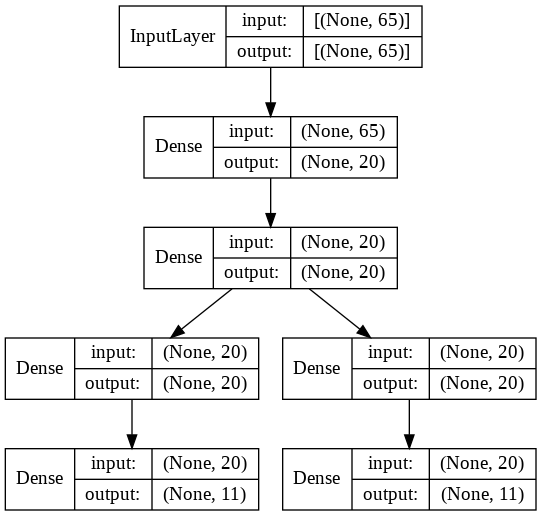

In [ ]:
tf.keras.utils.plot_model(ml_model, to_file="model.png", show_shapes=True, expand_nested=True, show_layer_names=False)

In [ ]:
list(dataset.as_numpy_iterator())[0]

(array([1.995e+03, 1.654e-02, 1.203e-02, 5.000e-04, 3.510e-03, 1.203e-02,
        3.208e-02, 1.000e-03, 4.010e-02, 5.510e-03, 2.005e-02, 7.520e-03,
        2.506e-02, 1.103e-02, 4.110e-02, 9.020e-03, 3.308e-02, 1.003e-02,
        5.013e-02, 1.554e-02, 1.103e-02, 2.356e-02, 3.208e-02, 1.203e-02,
        5.010e-03, 1.003e-02, 1.203e-02, 3.158e-02, 1.905e-02, 2.456e-02,
        1.353e-02, 2.155e-02, 2.510e-03, 6.520e-03, 1.500e-03, 1.554e-02,
        5.010e-03, 2.105e-02, 9.020e-03, 1.053e-02, 5.010e-03, 2.256e-02,
        3.010e-03, 3.108e-02, 4.010e-03, 2.607e-02, 2.510e-03, 1.153e-02,
        5.010e-03, 2.356e-02, 1.053e-02, 3.860e-02, 4.010e-03, 7.020e-03,
        4.010e-03, 4.510e-03, 1.303e-02, 3.559e-02, 1.003e-02, 4.612e-02,
        1.203e-02, 4.361e-02, 2.510e-03, 5.000e-04, 0.000e+00]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))